In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
import random

In [ ]:
import gdown

file_id = "1RQMtMCFHCrkMIJklYEcZ9oeB_WODpgjLr9yNIlQucC8"
filename = "violence_text_preprocessed.xlsx"

url = f"https://docs.google.com/spreadsheets/d/{file_id}/export?format=xlsx"

# Download
gdown.download(url, filename, quiet=False)

df = pd.read_excel(filename)

df.head()

/usr/local/lib/python3.12/dist-packages/gdown/parse_url.py:48: UserWarning: You specified a Google Drive link that is not the correct link to download a file. You might want to try `--fuzzy` option or the following url: https://drive.google.com/uc?id=None
  warnings.warn(
Downloading...
From: https://docs.google.com/spreadsheets/d/1RQMtMCFHCrkMIJklYEcZ9oeB_WODpgjLr9yNIlQucC8/export?format=xlsx
To: /content/violence_text_preprocessed.xlsx
610kB [00:00, 1.38MB/s]


,Clean_Text,label
0,যে দেশে সন্ত্রাসরা দেশ চালায়সে দেশে শান্তি কিভ...,1
1,এই বিচার শেষ বিচার নয়আসল বিচার হবে আল্লাহর আদা...,0
2,আরব দেশগুলোকে বলব ভারতের সাথে সব ব্যবসা বাণিজ্...,2
3,দেশটা সুস্থ নাই,0
4,আপনার কথা দুঃখ জনক আগে বিডিও থাকলে কেন ধরা হলন...,0


In [ ]:
df.shape

(11933, 2)

In [ ]:
X = df["Clean_Text"]
y = df["label"]

### **Stratified Train / Val / Test Split**

In [ ]:
# First split: Train (70%) + Temp (30%)
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

for train_idx, temp_idx in sss1.split(X, y):
    X_train, X_temp = X.iloc[train_idx], X.iloc[temp_idx]
    y_train, y_temp = y.iloc[train_idx], y.iloc[temp_idx]

# Second split: Validation (15%) + Test (15%)

sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)

for val_idx, test_idx in sss2.split(X_temp, y_temp):
    X_val, X_test = X_temp.iloc[val_idx], X_temp.iloc[test_idx]
    y_val, y_test = y_temp.iloc[val_idx], y_temp.iloc[test_idx]

print("Train:", y_train.value_counts())
print("Validation:", y_val.value_counts())
print("Test:", y_test.value_counts())

Train: label
0    3606
1    2735
2    2012
Name: count, dtype: int64
Validation: label
0    773
1    586
2    431
Name: count, dtype: int64
Test: label
0    773
1    586
2    431
Name: count, dtype: int64


In [ ]:
train_df = pd.DataFrame({"text": X_train, "label": y_train})
val_df   = pd.DataFrame({"text": X_val,   "label": y_val})
test_df  = pd.DataFrame({"text": X_test,  "label": y_test})

In [ ]:
print('train data: ',train_df.shape)
print('validation data: ',val_df.shape)
print('test data: ',test_df.shape)

train data:  (8353, 2)
validation data:  (1790, 2)
test data:  (1790, 2)


In [ ]:
train_df.columns

Index(['text', 'label'], dtype='object')

In [ ]:
import transformers
print(transformers.__version__)

4.57.3


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [ ]:
# Load tokenizer
MODEL_NAME = "csebuetnlp/banglabert"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
# Load model
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=3  # classification head is adjusted for 3 classes
)

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# create dataset classes

MAX_LEN = 256  # max token length for Bangla sentences

class ViolenceDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=MAX_LEN):
        self.texts = df['text'].tolist()
        self.labels = df['label'].tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])

        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt',
            add_special_tokens=True
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create dataset objects -> comment-out for cv
# train_dataset = ViolenceDataset(train_df, tokenizer)
# val_dataset = ViolenceDataset(val_df, tokenizer)


In [ ]:
# Compute class weights

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)

class_weights = torch.tensor(class_weights, dtype=torch.float)


In [ ]:
# Define compute_metrics function

# def compute_metrics(pred):
#     labels = pred.label_ids
#     preds = np.argmax(pred.predictions, axis=1)
#     acc = accuracy_score(labels, preds)
#     f1 = f1_score(labels, preds)
#     precision = precision_score(labels, preds)
#     recall = recall_score(labels, preds)
#     return {
#         'accuracy': acc,
#         'f1': f1,
#         'precision': precision,
#         'recall': recall
#     }


import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro"),
        "precision_macro": precision_score(labels, preds, average="macro", zero_division=0),
        "recall_macro": recall_score(labels, preds, average="macro", zero_division=0),
    }


### k-fold CV

In [ ]:
import torch
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from torch.nn import CrossEntropyLoss

# ---- Weighted Trainer ----
class WeightedTrainer(Trainer):
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False,  **kwargs):
        labels = inputs.pop("labels").long()   # <-- IMPORTANT
        outputs = model(**inputs)
        logits = outputs.logits

        loss_fn = CrossEntropyLoss(
            weight=self.class_weights.to(logits.device)
        )
        loss = loss_fn(logits, labels)

        return (loss, outputs) if return_outputs else loss


# ---- Cross Validation on TRAIN SET ONLY ----
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_results = []

num_labels = 3

for fold, (train_idx, val_idx) in enumerate(
    kf.split(train_df.index, train_df["label"])
):
    print(f"\n===== Fold {fold + 1} =====")

    # Split folds
    train_df_fold = train_df.iloc[train_idx].reset_index(drop=True)
    val_df_fold   = train_df.iloc[val_idx].reset_index(drop=True)

    # Dataset
    train_dataset = ViolenceDataset(train_df_fold, tokenizer)
    val_dataset   = ViolenceDataset(val_df_fold, tokenizer)

    # ---- Class Weights (from TRAIN fold only) ----
    class_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(train_df_fold["label"]),
        y=train_df_fold["label"]
    )
    class_weights = torch.tensor(class_weights, dtype=torch.float)

    # ---- Model ----
    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=num_labels
    )

    # ---- Training Args ----
    training_args = TrainingArguments(
        output_dir=f"./results_fold{fold+1}",
        num_train_epochs=5,
        learning_rate=3e-5,
        warmup_ratio=0.1,
        weight_decay=0.01,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        gradient_accumulation_steps=2,
        eval_strategy="steps",
        eval_steps=100,
        logging_steps=50,
        save_strategy="steps",
        save_steps=200,
        save_total_limit=1,
        load_best_model_at_end=True,
        metric_for_best_model="f1_macro",
        greater_is_better=True,
        fp16=torch.cuda.is_available(),
        report_to="none",
    )

    # ---- Trainer ----
    trainer = WeightedTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        class_weights=class_weights
    )

    # ---- Train & Evaluate ----
    trainer.train()
    metrics = trainer.evaluate()
    fold_results.append(metrics)

    print(f"Fold {fold+1} metrics:", metrics)


# ---- Average CV Metrics ----
avg_metrics = {
    k: np.mean([fold[k] for fold in fold_results])
    for k in fold_results[0].keys()
}

print("\n===== Average CV Metrics =====")
print(avg_metrics)



===== Fold 1 =====


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro
100,0.929200,0.726654,0.728306,0.716747,0.726102,0.725324
200,0.647800,0.586856,0.777977,0.775025,0.773192,0.777762
300,0.534400,0.558563,0.797127,0.791729,0.795225,0.788940
400,0.421700,0.556388,0.791143,0.786190,0.783884,0.798710
500,0.300600,0.607643,0.803112,0.799086,0.802632,0.799828
600,0.259800,0.586435,0.815081,0.808121,0.811955,0.804991
700,0.177700,0.604474,0.825254,0.818653,0.820610,0.816893
800,0.204500,0.605062,0.825254,0.819812,0.818221,0.821599
900,0.111300,0.620981,0.829443,0.823489,0.822426,0.824762
1000,0.129800,0.643163,0.832436,0.826147,0.825913,0.826407


Fold 1 metrics: {'eval_loss': 0.64316326379776, 'eval_accuracy': 0.8324356672651108, 'eval_f1_macro': 0.826147338915487, 'eval_precision_macro': 0.8259133932205883, 'eval_recall_macro': 0.826407294151574, 'eval_runtime': 8.3504, 'eval_samples_per_second': 200.111, 'eval_steps_per_second': 6.347, 'epoch': 5.0}

===== Fold 2 =====


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro
100,0.924000,0.716046,0.708558,0.706351,0.706461,0.724796
200,0.625700,0.609584,0.762418,0.754853,0.772287,0.753526
300,0.474900,0.554498,0.786355,0.783437,0.780406,0.789386
400,0.484000,0.520934,0.803112,0.799972,0.795687,0.806672
500,0.286300,0.582258,0.812687,0.808804,0.809572,0.808232
600,0.291200,0.582140,0.801915,0.797736,0.794565,0.808567
700,0.187600,0.649502,0.813884,0.808406,0.807875,0.809586
800,0.161400,0.645151,0.821065,0.817702,0.816552,0.819105
900,0.113900,0.697601,0.821065,0.817946,0.817262,0.818658
1000,0.123500,0.697451,0.821065,0.817551,0.815119,0.820858


Fold 2 metrics: {'eval_loss': 0.6451513171195984, 'eval_accuracy': 0.8210652304009575, 'eval_f1_macro': 0.8177016198761535, 'eval_precision_macro': 0.816551935161276, 'eval_recall_macro': 0.8191050678782353, 'eval_runtime': 8.3303, 'eval_samples_per_second': 200.593, 'eval_steps_per_second': 6.362, 'epoch': 5.0}

===== Fold 3 =====


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro
100,0.927400,0.710594,0.733094,0.735349,0.740471,0.735876
200,0.637800,0.597208,0.777977,0.772761,0.790831,0.770959
300,0.463500,0.532317,0.806703,0.807554,0.806802,0.808880
400,0.491100,0.520044,0.793537,0.790826,0.787974,0.806401
500,0.287600,0.538709,0.816876,0.814283,0.819849,0.811952
600,0.295800,0.500639,0.834829,0.833803,0.836788,0.832199
700,0.187500,0.534454,0.837223,0.837586,0.837133,0.838236
800,0.159100,0.579560,0.840215,0.839353,0.841828,0.837194
900,0.131800,0.593358,0.839019,0.838358,0.838892,0.837864
1000,0.127500,0.621760,0.838420,0.837973,0.839585,0.836684


Fold 3 metrics: {'eval_loss': 0.5795598030090332, 'eval_accuracy': 0.8402154398563735, 'eval_f1_macro': 0.839352635191401, 'eval_precision_macro': 0.8418276317345663, 'eval_recall_macro': 0.8371940168529027, 'eval_runtime': 8.3134, 'eval_samples_per_second': 201.001, 'eval_steps_per_second': 6.375, 'epoch': 5.0}

===== Fold 4 =====


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro
100,0.926100,0.725979,0.734731,0.728379,0.736926,0.726156
200,0.643700,0.588551,0.773054,0.773035,0.775631,0.773014
300,0.494600,0.542479,0.786826,0.784933,0.780083,0.795963
400,0.472500,0.541309,0.785030,0.783099,0.779560,0.800520
500,0.317200,0.532851,0.804192,0.804761,0.799822,0.812976
600,0.288900,0.533698,0.818563,0.815486,0.812262,0.823991
700,0.189600,0.611521,0.825150,0.822544,0.834998,0.814772
800,0.195600,0.572638,0.827545,0.828763,0.825869,0.832920
900,0.145100,0.592019,0.830539,0.830201,0.825462,0.837062
1000,0.135800,0.603743,0.829341,0.829369,0.825645,0.834084


Fold 4 metrics: {'eval_loss': 0.5726379156112671, 'eval_accuracy': 0.8275449101796407, 'eval_f1_macro': 0.8287627976755769, 'eval_precision_macro': 0.8258691594837737, 'eval_recall_macro': 0.832919518600819, 'eval_runtime': 7.8479, 'eval_samples_per_second': 212.796, 'eval_steps_per_second': 6.753, 'epoch': 5.0}

===== Fold 5 =====


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro
100,0.939900,0.755763,0.682635,0.685025,0.693909,0.710018
200,0.597700,0.618647,0.758683,0.755008,0.752664,0.764904
300,0.462200,0.647735,0.748503,0.744665,0.747022,0.765555
400,0.451500,0.615568,0.784431,0.779996,0.797202,0.769682
500,0.310300,0.611569,0.800000,0.798713,0.808037,0.792778
600,0.272100,0.610550,0.799401,0.799877,0.797192,0.804290
700,0.178600,0.643962,0.805389,0.805959,0.801601,0.813317
800,0.201300,0.641367,0.808982,0.809046,0.804155,0.816233
900,0.119900,0.696634,0.811377,0.810837,0.812840,0.809420
1000,0.128900,0.700771,0.822156,0.822155,0.821761,0.822962


Fold 5 metrics: {'eval_loss': 0.7007713913917542, 'eval_accuracy': 0.8221556886227545, 'eval_f1_macro': 0.8221552559278914, 'eval_precision_macro': 0.8217611256937905, 'eval_recall_macro': 0.8229615054176419, 'eval_runtime': 7.8471, 'eval_samples_per_second': 212.817, 'eval_steps_per_second': 6.754, 'epoch': 5.0}

===== Average CV Metrics =====
{'eval_loss': np.float64(0.6282567381858826), 'eval_accuracy': np.float64(0.8286833872649675), 'eval_f1_macro': np.float64(0.826823929517302), 'eval_precision_macro': np.float64(0.826384649058799), 'eval_recall_macro': np.float64(0.8277174805802346), 'eval_runtime': np.float64(8.137820000000001), 'eval_samples_per_second': np.float64(205.46359999999999), 'eval_steps_per_second': np.float64(6.5182), 'epoch': np.float64(5.0)}


# HMS Edition Fine Tuning

In [ ]:
# # Define TrainingArguments

# # training_args = TrainingArguments(
# #     output_dir="./results",
# #     num_train_epochs=30,
# #     max_steps=500,

# #     learning_rate=1e-5,
# #     per_device_train_batch_size=16,
# #     per_device_eval_batch_size=16,

# #     eval_strategy="steps",
# #     eval_steps=30,

# #     logging_strategy="steps",
# #     logging_steps=1,
# #     logging_first_step=True,

# #     save_strategy="steps",
# #     save_steps=500,
# #     save_total_limit=1,

# #     fp16=torch.cuda.is_available(),
# #     report_to="none",
# #     disable_tqdm=False,
# # )

# # MY MODEL
# training_args = TrainingArguments(
#     output_dir="./results",
#     num_train_epochs=5,
#     max_steps=-1,

#     learning_rate=3e-5,
#     weight_decay=0.01,
#     warmup_ratio=0.1,

#     per_device_train_batch_size=16,
#     per_device_eval_batch_size=32,
#     gradient_accumulation_steps=2,

#     eval_strategy="steps",
#     eval_steps=200,

#     logging_strategy="steps",
#     logging_steps=20,
#     logging_first_step=True,

#     save_strategy="steps",
#     save_steps=200,
#     save_total_limit=2,

#     load_best_model_at_end=True,
#     metric_for_best_model="f1_macro",
#     greater_is_better=True,

#     fp16=torch.cuda.is_available(),
#     max_grad_norm=1.0,

#     report_to="none",
#     disable_tqdm=False,
# )

In [ ]:
# # Custom loss with class weights

# from torch.nn import CrossEntropyLoss
# from transformers import Trainer

# class WeightedTrainer(Trainer):
#     def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
#         labels = inputs.pop("labels").long()
#         outputs = model(**inputs)
#         logits = outputs.get("logits")
#         loss_fn = CrossEntropyLoss(
#             weight=class_weights.to(logits.device)
#         )
#         loss = loss_fn(logits, labels)
#         return (loss, outputs) if return_outputs else loss

In [ ]:
# # Initialize Trainer

# trainer = WeightedTrainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_dataset,
#     eval_dataset=val_dataset,
#     tokenizer=tokenizer,
#     compute_metrics=compute_metrics
# )


In [ ]:
# training_args = training_args.replace(max_steps=50)
# trainer.train()

In [ ]:
eval_results = trainer.evaluate()
print(eval_results)

{'eval_loss': 0.7007713913917542, 'eval_accuracy': 0.8221556886227545, 'eval_f1_macro': 0.8221552559278914, 'eval_precision_macro': 0.8217611256937905, 'eval_recall_macro': 0.8229615054176419, 'eval_runtime': 9.2036, 'eval_samples_per_second': 181.45, 'eval_steps_per_second': 5.759, 'epoch': 5.0}


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

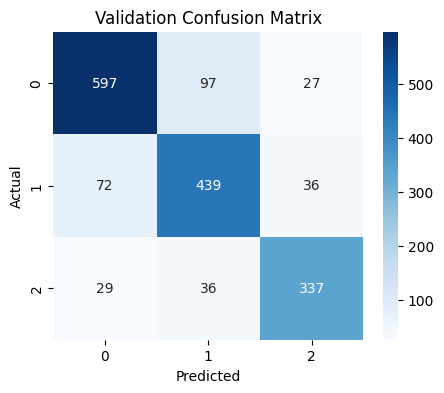

In [ ]:
# Get validation predictions
val_predictions = trainer.predict(val_dataset)
val_preds = np.argmax(val_predictions.predictions, axis=1)
val_labels = val_predictions.label_ids

# Compute confusion matrix
cm_val = confusion_matrix(val_labels, val_preds)

# Display
plt.figure(figsize=(5,4))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Validation Confusion Matrix')
plt.show()

In [ ]:
# convert test data

test_dataset = ViolenceDataset(test_df, tokenizer)


In [ ]:
# Get predictions from the trained model

predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)

In [ ]:
# Add a new column for predicted labels
test_df['predicted_label'] = preds

# Save to CSV
test_df.to_csv("bangla_violence_test_predictions.csv", index=False)

# Check first few rows
print(test_df.head())


                                                    text  label  \
2396           যারা মারছে তাদের বিচার হোক ফোটেজ দেখে হোক      0   
11372                       ভুট তুদের পিচন দিয়ে দেয়া হবে      2   
272    ষড়যন্ত্রকারীরা কত শক্তিশালী! অঘটন ঘটানোর জন্য...      0   
4139   এরকম শিক্ষা প্রথিসঠানের নোংরামী কর্ম কান্ডকে ধ...      0   
7839   সারা পৃথিবীর মতপ্রকাশের স্বাধীনতা শুধু ইসলামের...      0   

       predicted_label  
2396                 0  
11372                2  
272                  1  
4139                 0  
7839                 0  


In [ ]:
eval_results = trainer.evaluate()
print(eval_results)

{'eval_loss': 0.7007713913917542, 'eval_accuracy': 0.8221556886227545, 'eval_f1_macro': 0.8221552559278914, 'eval_precision_macro': 0.8217611256937905, 'eval_recall_macro': 0.8229615054176419, 'eval_runtime': 10.2223, 'eval_samples_per_second': 163.368, 'eval_steps_per_second': 5.185, 'epoch': 5.0}


In [ ]:
from sklearn.metrics import classification_report

predictions = trainer.predict(test_dataset)

y_pred = np.argmax(predictions.predictions, axis=1)

y_true = predictions.label_ids

In [ ]:
print(
    classification_report(
        y_true,
        y_pred,
        target_names=["class_0", "class_1", "class_2"],
        digits=2
    )
)

              precision    recall  f1-score   support

     class_0       0.84      0.81      0.83       773
     class_1       0.74      0.80      0.77       586
     class_2       0.83      0.80      0.81       431

    accuracy                           0.80      1790
   macro avg       0.80      0.80      0.80      1790
weighted avg       0.81      0.80      0.81      1790



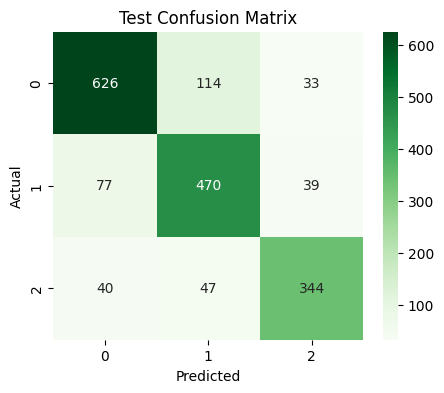

In [ ]:
# Confusion Matrix

if 'label' in test_df.columns:
    test_labels = test_df['label'].values
    cm_test = confusion_matrix(test_labels, preds)

    plt.figure(figsize=(5,4))
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Test Confusion Matrix')
    plt.show()
else:
    print("No true labels in test set; cannot compute confusion matrix for test data.")
